In [1]:
# imports
import json, re, time, unicodedata, unidecode, itertools, os
from collections import defaultdict
from datetime import date, datetime, timedelta
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from pattern.nl import sentiment, parse, split
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
# zorg voor een nieuwe versie van dit bestand; verkeerd opgeslagen dus je mist het kontje!
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

In [53]:
store = defaultdict(list)

In [88]:
responders = set()
with tqdm(total=len(topics)) as pbar:
    for t in topics:
        pbar.update(1)
        for p in posts:
            if t["Nid"] == p["Forum Topic ID"]:
                responders.add(p["Auteur-uid"])
                store[t["Author uid"]][p["Auteur-uid"]] = 1

A Jupyter Widget

In [94]:
for user in responders:
    if user not in store:
        store[user]={}

In [97]:
print len(store)

2193


In [98]:
with open('graph.json', 'w') as f:
    json.dump(store, f)
    
#store # key = thread starter, values are responders

In [99]:
graph = json.load(open('graph.json'))

In [100]:
print graph['4022']

{u'4877': 1, u'755': 1, u'1981': 1, u'1783': 1, u'4911': 1, u'2662': 1, u'4022': 1, u'917': 1}


In [50]:
# for graph in dictionary format
def find_shortest_path(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return path
    if not graph.has_key(start):
        return None
    shortest = None
    for node in graph[start]:
        if node not in path:
            newpath = find_shortest_path(graph, node, end, path)
            if newpath:
                if not shortest or len(newpath) < len(shortest):
                    shortest = newpath
    return shortest


In [51]:
print find_shortest_path(unique_graph,'1144','1527')

KeyboardInterrupt: 

In [74]:
# Karnstedt berekende een aantal dingen:

# In-degree; number of 'incoming connections' (replies to user)
in_degree = dict()
for user in store:
    in_degree[user] = len(store[user])
#print in_degree

# Out-degree; number of outgoing connections (user replies)
out_degree = defaultdict(int)
responses = 0
for user in store:
    for responder in store[user]:
        out_degree[responder] +=1
#print out_degree

# Betweenness centrality
# Reciprocity
# Average post in initiations
# Average post in participations
# Popularity
# Initialisation
# Polarity

In [98]:
# make graph type out of 
G = nx.from_dict_of_lists(store)

In [115]:
graph = {'a':{'b':10,'c':3},'b':{'c':1,'d':2},'c':{'b':4,'d':8,'e': 2},'d':{'e':7},'e':{'d':9}}

In [233]:
# from youtube video.

def dijkstra(G,start,goal):
    shortest_distance = {}
    predecessor = {}
    unseenNodes = copy.deepcopy(G)
    infinity = 999999
    path = []
    for node in unseenNodes:
        shortest_distance[node] = infinity
    shortest_distance[start]=0
    
    while unseenNodes:
        minNode = None
        for node in unseenNodes:
            if minNode is None:
                minNode = node
            elif shortest_distance[node] < shortest_distance[minNode]:
                minNode = node
        
        # main part of algorithm
        for childNode, weight in graph[minNode].items():
            if weight + shortest_distance[minNode] < shortest_distance[childNode]:
                shortest_distance[childNode] = weight + shortest_distance[minNode]
                predecessor[childNode] = minNode
        unseenNodes.pop(minNode)
    
    currentNode = goal
    while currentNode != start:
        try:
            path.insert(0,currentNode)
            currentNode = predecessor[currentNode]
        except KeyError:
            #print 'path not reachable'
            return None
            break
    path.insert(0,start)
    if shortest_distance[goal] != infinity:
        #print 'shortest distance is ' + str(shortest_distance[goal])
        #print 'and the path is ' + str(path)
        return path


In [202]:
def test(anything):
    something = list(anything)
    while something:
        for node in something:
            print node,something
            something.pop(node)
        

In [203]:
anything = {'A':{'B':1,'C':1}, 'B':{'A':1}}

test(anything)

A ['A', 'B']


TypeError: an integer is required

In [130]:
graph = {'a':{'b':10,'c':3},'b':{'c':1,'d':2},'c':{'b':4,'d':8,'e': 2},'d':{'e':7},'e':{}}
length = dijkstra(graph, 'e','a')
print float('nan') if length == None else length

nan


In [234]:
graph = json.load(open('graph.json'))
print dijkstra(graph, '4024','4029')
print dijkstra(graph, '4024','4029')

['4024', u'1783', u'1', u'1303', '4029']
['4024', u'1783', u'1', u'1303', '4029']


In [235]:
# Closeness centrality
# for all users, for all users: determine closeness between the two, determine average, then inverse
closeness_centrality = dict()
graph = json.load(open('graph.json'))

with tqdm(total=len(graph)) as pbar:
    for user_i in graph: # 893 users
        close = []
        pbar.update(1)
        for user_j in graph:
            if user_i != user_j:
                path = dijkstra(graph,user_i,user_j)
                length = float('nan') if path is None else len(path) 
                close.append(length)
        print close
        closeness_centrality[user_i] = np.nanmean(close)
print closeness_centrality

A Jupyter Widget

KeyboardInterrupt: 

In [92]:
# this one is from pyalgoviz, very nice visualisation as well!! (but only for the given graph :()
import heapq

def shortestPath(graph, start, end):
    queue,seen = [(0, start, [])], set()
    while True:
        (cost, v, path) = heapq.heappop(queue)
        if v not in seen:
            path = path + [v]
            seen.add(v)
            if v == end:
                return cost, path
            for (next, c) in graph[v].iteritems():
                heapq.heappush(queue, (cost + c, next, path))
			
graph = { 
   'a': {'w':1, 'x': 1, 'y': 1}, 
   'b': {'w': 1, 'z': 1}, 
   'w': {'a': 1, 'b': 1, 'y': 1}, 
   'x': {'a': 1, 'y': 1, 'z': 1}, 
   'y': {'a': 1, 'w': 1, 'x': 1, 'z': 1}, 
   'z': {'b': 1, 'x': 1, 'y': 1}, 
}
cost, path = shortestPath(graph, 'a', z')
print cost, path
# Based on http://code.activestate.com/recipes/119466

2 ['a', 'x', 'z']


In [83]:
print closeness_centrality

{'A': 2.3333333333333335, 'C': 2.25, 'B': 2.1666666666666665, 'E': 2.4444444444444446, 'D': 2.4, 'F': 2.4166666666666665}


In [61]:
graph = {'A': ['B', 'C'],
             'B': ['C', 'D'],
             'C': ['D'],
             'D': ['C'],
             'E': ['F'],
             'F': ['C']}

In [92]:
def find_path(graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return path
        if not graph.has_key(start):
            return None
        for node in graph[start]:
            if node not in path:
                newpath = find_path(graph, node, end, path)
                if newpath: return newpath
        return None

In [98]:
def find_all_paths(graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return [path]
        if not graph.has_key(start):
            return []
        paths = []
        for node in graph[start]:
            if node not in path:
                newpaths = find_all_paths(graph, node, end, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

In [70]:
if find_shortest_path(graph, 'A', 'F') is None:
    print True

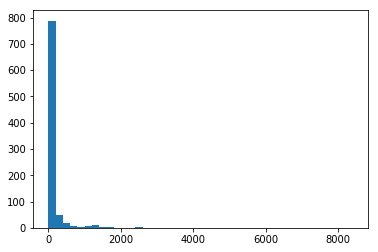

In [89]:
lengths = []
for x in store:
    lengths.append(len(store[x]))
bins = [x for x in range(0,np.max(lengths),200)]
plt.hist(lengths, bins = bins)
plt.show()

In [5]:
def make_P_T_and_D(topics,posts):
    """ this function takes the .json files containing the thread starts and responses, and returns three things:
    [0]: a dictionary with the user-ID as key, and the post as value;
    [1]: a dictionary with the user-ID as key, and the time of posting as a value;
    [2]: a list of all datetimes present in the data (sorted by date, because the .json was already sorted) """
    P = defaultdict(list)
    T = defaultdict(list)
    D = []

    with tqdm(total=len(topics)) as pbar:
        for t in reversed(topics):
            pbar.update(1)
            P[t['Author uid']].append((cleanup(t["Body"]),1))
            T[t['Author uid']].append(t['Post date'])
            D.append(datetime.strptime(t['Post date'], '%d/%m/%Y - %H:%M'))

    with tqdm(total=len(posts)) as pbar:
        for p in reversed(posts):
            pbar.update(1)
            P[p['Auteur-uid']].append((cleanup(p["Body"]),0))
            T[p['Auteur-uid']].append(p['Datum van inzending'])
            D.append(datetime.strptime(p['Datum van inzending'], '%d/%m/%Y - %H:%M'))

    return (P,T,D)